# Execute Quantum Dynamics with PyTDSCF --Taylor expansion PES

In [1]:
try:
    import pytdscf
except ModuleNotFoundError:
    !uv pip install -U git+https://github.com/QCLovers/PyTDSCF --quiet
try:
    import discvar
except ModuleNotFoundError:
    !uv pip install -U git+https://github.com/QCLovers/Discvar --quiet

/Users/hinom/GitHub/PyMPO/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import itertools
from collections import defaultdict
from math import factorial, sqrt

import numpy as np
import sympy
from discvar import HarmonicOscillator as HO
from pytdscf import Model, Simulator, units
from pytdscf.potentials.ch2o_potential import k_orig

import pympo

In [3]:
backend = "jax"
m = 30
N = 9
Δt = 0.1
cutoff = 0.0  # 1.e-09

$$
V - V_0 = \frac{k_{11}}{2!} Q_1^2 + \frac{k_{22}}{2!} Q_2^2 + \frac{k_{33}}{2!} Q_3^2 + \frac{k_{111}}{3!} Q_1^3 + \frac{k_{122}}{2!} Q_1Q_2^2 + \cdots
$$

In [4]:
print(f"{len(k_orig)=}")
active_modes = sorted(list(set(itertools.chain.from_iterable(k_orig.keys()))))
index = {}
for i, mode in enumerate(active_modes):
    index[mode] = i
print(f"{index=}")
f = len(active_modes)
k_new = {}
for key, value in k_orig.items():
    new_key = tuple([index[k] for k in key])
    if abs(value) > cutoff:
        k_new[new_key] = value
print(f"{len(k_new)=}")

len(k_orig)=114
index={1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}
len(k_new)=114


In [5]:
k_new

{(0, 0): 2.881141028397287e-05,
 (1, 1): 3.2448494255464496e-05,
 (2, 2): 4.725466264016419e-05,
 (3, 3): 6.805132227202656e-05,
 (4, 4): 0.00017348287106252062,
 (5, 5): 0.0001808886981537931,
 (2, 2, 2): -1.1756574314828089e-07,
 (3, 3, 3): 1.956730822300732e-06,
 (4, 4, 4): 9.330094468538158e-06,
 (5, 5, 5): -9.893510625593033e-09,
 (0, 0, 2): -1.238616135463855e-07,
 (1, 1, 2): 2.3333266618281752e-07,
 (0, 3, 3): 7.709229058903663e-10,
 (0, 0, 3): 6.899760007718777e-08,
 (1, 1, 3): 4.7154784410294076e-08,
 (2, 3, 3): 3.410048987055054e-07,
 (2, 2, 3): 2.858839109343442e-07,
 (0, 4, 4): 2.955204472579738e-09,
 (0, 0, 4): -9.109739004604497e-07,
 (1, 1, 4): -6.881771806581336e-07,
 (2, 4, 4): -7.439406041842036e-08,
 (2, 2, 4): -3.3560843836427284e-07,
 (3, 4, 4): -9.31531844617526e-08,
 (3, 3, 4): -2.9128037127557674e-07,
 (0, 5, 5): 3.2121787745431932e-09,
 (2, 5, 5): 6.435921392674742e-07,
 (3, 5, 5): -6.933166666974028e-07,
 (4, 5, 5): 1.0040242952014167e-05,
 (4, 4, 5): 3.469153

In [6]:
freqs = [
    sqrt(k_new[(k, k)]) * units.au_in_cm1 for k in range(f)
]  # a.u. (sqrt{omega^2} = omega)
freqs  # in cm^{-1}

[1178.0577664327557,
 1250.2060681419946,
 1508.7131015740217,
 1810.5170221727915,
 2890.7639406635694,
 2951.821181689732]

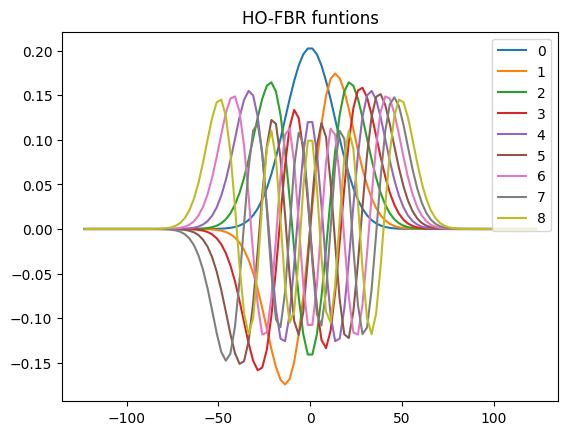

In [7]:
nprims = [N] * f  # Number of primitive basis
dvr_prims = [
    # HO(ngrid=nprim, omega=omega, units='cm-1')
    HO(nprim, omega)
    for nprim, omega in zip(nprims, freqs, strict=True)
]
dvr_prims_redundant = [
    # HO(ngrid=nprim, omega=omega, units='cm-1')
    HO(nprim+4, omega)
    for nprim, omega in zip(nprims, freqs, strict=True)
]
ndof = len(dvr_prims)  # Number of degree of freedom

dvr_prims[0].plot_fbr()

In [8]:
dq2 = [prim.get_2nd_derivative_matrix_fbr() for prim in dvr_prims]
q_scale = 10
q1 = [prim.get_pos_rep_matrix() / q_scale for prim in dvr_prims_redundant]
q2 = [ints @ ints for ints in q1]
q3 = [ints @ ints @ ints for ints in q1]
q4 = [ints @ ints @ ints @ ints for ints in q1]
qn = [[ints[:N, :N] for ints in q] for q in [q1, q2, q3, q4]]

In [9]:
kinetic_sop = pympo.SumOfProducts([])
for isite in range(f):
    kinetic_sop -= (
        1
        / 2
        * pympo.OpSite(
            r"\frac{\partial}{\partial q^2_{" + f"{isite}" + r"}}",
            isite,
            value=dq2[isite],
        )
    )
kinetic_sop.symbol

-0.5*\frac{\partial}{\partial q^2_{0}} - 0.5*\frac{\partial}{\partial q^2_{1}} - 0.5*\frac{\partial}{\partial q^2_{2}} - 0.5*\frac{\partial}{\partial q^2_{3}} - 0.5*\frac{\partial}{\partial q^2_{4}} - 0.5*\frac{\partial}{\partial q^2_{5}}

In [10]:
potential_sop = pympo.SumOfProducts([])
coef_symbol = {}
for key, coef in k_new.items():
    cnt_site = defaultdict(int)
    for isite in key:
        cnt_site[isite] += 1
    op = 1
    coef_sym = sympy.Symbol(f"k_{key}")
    for isite, order in cnt_site.items():
        coef /= factorial(order)
        op *= pympo.OpSite(
            f"q^{order}" + r"_{" + f"{isite}" + r"}",
            isite,
            value=qn[order - 1][isite],
        )
    op *= coef_sym
    coef_symbol[coef_sym] = coef * (q_scale ** len(key))
    potential_sop += op
potential_sop.symbol

k_(0, 0)*q^2_{0} + k_(0, 0, 0, 0)*q^4_{0} + k_(0, 0, 0, 1)*q^3_{0}*q^1_{1} + k_(0, 0, 0, 4)*q^3_{0}*q^1_{4} + k_(0, 0, 0, 5)*q^3_{0}*q^1_{5} + k_(0, 0, 1, 1)*q^2_{0}*q^2_{1} + k_(0, 0, 1, 5)*q^2_{0}*q^1_{1}*q^1_{5} + k_(0, 0, 2)*q^2_{0}*q^1_{2} + k_(0, 0, 2, 2)*q^2_{0}*q^2_{2} + k_(0, 0, 2, 3)*q^2_{0}*q^1_{2}*q^1_{3} + k_(0, 0, 2, 4)*q^2_{0}*q^1_{2}*q^1_{4} + k_(0, 0, 3)*q^2_{0}*q^1_{3} + k_(0, 0, 3, 3)*q^2_{0}*q^2_{3} + k_(0, 0, 3, 4)*q^2_{0}*q^1_{3}*q^1_{4} + k_(0, 0, 4)*q^2_{0}*q^1_{4} + k_(0, 0, 4, 4)*q^2_{0}*q^2_{4} + k_(0, 0, 5, 5)*q^2_{0}*q^2_{5} + k_(0, 1, 1, 1)*q^1_{0}*q^3_{1} + k_(0, 1, 1, 2)*q^1_{0}*q^2_{1}*q^1_{2} + k_(0, 1, 1, 3)*q^1_{0}*q^2_{1}*q^1_{3} + k_(0, 1, 1, 4)*q^1_{0}*q^2_{1}*q^1_{4} + k_(0, 1, 2, 2)*q^1_{0}*q^1_{1}*q^2_{2} + k_(0, 1, 3, 3)*q^1_{0}*q^1_{1}*q^2_{3} + k_(0, 1, 4)*q^1_{0}*q^1_{1}*q^1_{4} + k_(0, 1, 4, 4)*q^1_{0}*q^1_{1}*q^2_{4} + k_(0, 1, 5)*q^1_{0}*q^1_{1}*q^1_{5} + k_(0, 1, 5, 5)*q^1_{0}*q^1_{1}*q^2_{5} + k_(0, 2, 2, 4)*q^1_{0}*q^2_{2}*q^1_{4} + k

In [11]:
coef_symbol

{k_(0, 0): 0.0014405705141986437,
 k_(1, 1): 0.001622424712773225,
 k_(2, 2): 0.002362733132008209,
 k_(3, 3): 0.003402566113601328,
 k_(4, 4): 0.008674143553126032,
 k_(5, 5): 0.009044434907689655,
 k_(2, 2, 2): -1.959429052471348e-05,
 k_(3, 3, 3): 0.00032612180371678867,
 k_(4, 4, 4): 0.0015550157447563595,
 k_(5, 5, 5): -1.6489184375988388e-06,
 k_(0, 0, 2): -6.193080677319275e-05,
 k_(1, 1, 2): 0.00011666633309140877,
 k_(0, 3, 3): 3.8546145294518314e-07,
 k_(0, 0, 3): 3.4498800038593886e-05,
 k_(1, 1, 3): 2.3577392205147037e-05,
 k_(2, 3, 3): 0.0001705024493527527,
 k_(2, 2, 3): 0.0001429419554671721,
 k_(0, 4, 4): 1.477602236289869e-06,
 k_(0, 0, 4): -0.00045548695023022486,
 k_(1, 1, 4): -0.0003440885903290668,
 k_(2, 4, 4): -3.719703020921018e-05,
 k_(2, 2, 4): -0.0001678042191821364,
 k_(3, 4, 4): -4.65765922308763e-05,
 k_(3, 3, 4): -0.00014564018563778837,
 k_(0, 5, 5): 1.6060893872715966e-06,
 k_(2, 5, 5): 0.0003217960696337371,
 k_(3, 5, 5): -0.0003466583333487014,
 k_(4,

In [12]:
hamiltonian_sop = pympo.SumOfProducts([])
hamiltonian_sop += kinetic_sop
hamiltonian_sop += potential_sop
hamiltonian_sop = hamiltonian_sop.simplify()
hamiltonian_sop.symbol

k_(0, 0)*q^2_{0} + k_(0, 0, 0, 0)*q^4_{0} + k_(0, 0, 0, 1)*q^3_{0}*q^1_{1} + k_(0, 0, 0, 4)*q^3_{0}*q^1_{4} + k_(0, 0, 0, 5)*q^3_{0}*q^1_{5} + k_(0, 0, 1, 1)*q^2_{0}*q^2_{1} + k_(0, 0, 1, 5)*q^2_{0}*q^1_{1}*q^1_{5} + k_(0, 0, 2)*q^2_{0}*q^1_{2} + k_(0, 0, 2, 2)*q^2_{0}*q^2_{2} + k_(0, 0, 2, 3)*q^2_{0}*q^1_{2}*q^1_{3} + k_(0, 0, 2, 4)*q^2_{0}*q^1_{2}*q^1_{4} + k_(0, 0, 3)*q^2_{0}*q^1_{3} + k_(0, 0, 3, 3)*q^2_{0}*q^2_{3} + k_(0, 0, 3, 4)*q^2_{0}*q^1_{3}*q^1_{4} + k_(0, 0, 4)*q^2_{0}*q^1_{4} + k_(0, 0, 4, 4)*q^2_{0}*q^2_{4} + k_(0, 0, 5, 5)*q^2_{0}*q^2_{5} + k_(0, 1, 1, 1)*q^1_{0}*q^3_{1} + k_(0, 1, 1, 2)*q^1_{0}*q^2_{1}*q^1_{2} + k_(0, 1, 1, 3)*q^1_{0}*q^2_{1}*q^1_{3} + k_(0, 1, 1, 4)*q^1_{0}*q^2_{1}*q^1_{4} + k_(0, 1, 2, 2)*q^1_{0}*q^1_{1}*q^2_{2} + k_(0, 1, 3, 3)*q^1_{0}*q^1_{1}*q^2_{3} + k_(0, 1, 4)*q^1_{0}*q^1_{1}*q^1_{4} + k_(0, 1, 4, 4)*q^1_{0}*q^1_{1}*q^2_{4} + k_(0, 1, 5)*q^1_{0}*q^1_{1}*q^1_{5} + k_(0, 1, 5, 5)*q^1_{0}*q^1_{1}*q^2_{5} + k_(0, 2, 2, 4)*q^1_{0}*q^2_{2}*q^1_{4} + k

In [13]:
hamiltonian_mpo = hamiltonian_sop.to_mpo(subs=coef_symbol)

In [14]:
operators = {"hamiltonian": hamiltonian_mpo}

In [15]:
model = Model(dvr_prims, operators=operators, bond_dim=m)
model.init_HartreeProduct = [
    [
        [1.0] + [0.0] * (N-1) for _ in range(f)
    ]
]

In [16]:
jobname = "ch2o-mpo"
simulator = Simulator(jobname=jobname, model=model, backend=backend)
import time
start = time.time()
ener, wf = simulator.relax(savefile_ext="_gs", maxstep=10, stepsize=0.1)#.(maxstep=100, stepsize=Δt)
end = time.time()
print(end-start)
ener * units.au_in_eV

19:42:26 | INFO | Log file is ./ch2o-mpo_relax/main.log
19:42:26 | INFO | Wave function is saved in wf_ch2o-mpo_gs.pkl
19:42:26 | INFO | Start initial step    0.000 [fs]
100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.06it/s]
19:42:29 | INFO | End     9 step; propagated    0.900 [fs]; AVG Krylov iteration: 3.17
19:42:29 | INFO | End simulation and save wavefunction
19:42:29 | INFO | Wave function is saved in wf_ch2o-mpo_gs.pkl


2.6824569702148438


0.7088296546416561

In [17]:
!tail ch2o-mpo_relax/main.log

2025-12-04 19:42:28 | DEBUG | pytdscf.properties:_export_properties:410 - | pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.400 | elapsed[sec]:     1.32 
2025-12-04 19:42:28 | DEBUG | pytdscf.properties:_export_properties:410 - | pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.500 | elapsed[sec]:     1.39 
2025-12-04 19:42:28 | DEBUG | pytdscf.properties:_export_properties:410 - | pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.600 | elapsed[sec]:     1.45 
2025-12-04 19:42:28 | DEBUG | pytdscf.properties:_export_properties:410 - | pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.700 | elapsed[sec]:     1.50 
2025-12-04 19:42:29 | DEBUG | pytdscf.properties:_export_properties:410 - | pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.800 | elapsed[sec]:     1.56 
2025-12-04 19:42:29 | INFO | pytdscf.simulator_cls:_execute:416 - Saved wavefunction    0.900 [fs]
2025-12-04 19:42:29 | DEBUG | pytdscf.properties:_export_properties:410 - | pop 1.0000 | ene[eV]:  0.7088297 | time[fs]: 

/Users/hinom/.local/share/uv/python/cpython-3.12.2-macos-aarch64-none/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Confirm with SOP model

In [18]:
from discvar import PrimBas_HO

prim_info = [
        PrimBas_HO(0.0, omega, nprim)
        for nprim, omega in zip(nprims, freqs, strict=True)
]
ndof = len(prim_info)  # Number of degree of freedom, H2O has 3 DOFs
from pytdscf.hamiltonian_cls import read_potential_nMR

hamiltonian = read_potential_nMR(k_orig, cut_off=cutoff)
operators = {"hamiltonian": hamiltonian}

model = Model(prim_info, operators, bond_dim=m)
model.init_HartreeProduct = [
    [
        [1.0] + [0.0] * (N-1) for _ in range(f)
    ]
]
jobname = "ch2o-sop"
simulator = Simulator(jobname, model, ci_type="MPS", backend="Numpy")

start = time.time()
ener, wf = simulator.relax(savefile_ext="_gs", maxstep=10, stepsize=0.1)
end = time.time()
print(end-start)
ener * units.au_in_eV

19:42:29 | INFO | Construct anharmonic polynomial operator
19:42:29 | INFO | Log file is ./ch2o-sop_relax/main.log
19:42:29 | WARNING | rebind const doDVR
19:42:29 | WARNING | rebind const use_jax
19:42:29 | WARNING | Employing sum of product Hamiltonian is deprecated.
19:42:29 | WARNING | rebind const use_mpo
19:42:29 | WARNING | Sum-of-Products (SOP) based calculation will be executed, but it is inefficient and will be deprecated, use Conventional MPO or Grid-MPO based calculation instead. See example such as https://qclovers.github.io/PyTDSCF/notebook/TD_reduced_density_exciton.html and https://kenhino.github.io/PyMPO/example/pytdscf-taylor.html
19:42:29 | INFO | Wave function is saved in wf_ch2o-sop_gs.pkl
19:42:29 | INFO | Start initial step    0.000 [fs]
100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]
19:42:41 | INFO | End     9 step; propagated    0.900 [fs]; AVG Krylov iteration: 3.17
19:42:41 | INFO | End

11.949464082717896


0.7088296546416549

In [19]:
!tail ch2o-sop_relax/main.log

2025-12-04 19:42:37 | DEBUG | pytdscf.properties:_export_properties:410 - | pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.400 | elapsed[sec]:     9.18 
2025-12-04 19:42:37 | DEBUG | pytdscf.properties:_export_properties:410 - | pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.500 | elapsed[sec]:     9.96 
2025-12-04 19:42:38 | DEBUG | pytdscf.properties:_export_properties:410 - | pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.600 | elapsed[sec]:    10.69 
2025-12-04 19:42:39 | DEBUG | pytdscf.properties:_export_properties:410 - | pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.700 | elapsed[sec]:    11.38 
2025-12-04 19:42:40 | DEBUG | pytdscf.properties:_export_properties:410 - | pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.800 | elapsed[sec]:    12.01 
2025-12-04 19:42:40 | INFO | pytdscf.simulator_cls:_execute:416 - Saved wavefunction    0.900 [fs]
2025-12-04 19:42:40 | DEBUG | pytdscf.properties:_export_properties:410 - | pop 1.0000 | ene[eV]:  0.7088297 | time[fs]: 